In [1]:

from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement

station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [196]:
# Find the most recent date in the data set.
starting_point = session.query(measurement.date).order_by(measurement.date.desc()).first()
starting_point =starting_point[0]
starting_point

'2017-08-23'

In [110]:
# Create connection for pandas
conn = engine.connect()

In [23]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


([<matplotlib.axis.XTick at 0x20d61c850c0>,
 [Text(0, 0, '2016-08-23'),
  Text(50, 0, '2016-10-12'),
  Text(100, 0, '2016-12-01'),
  Text(150, 0, '2017-01-20'),
  Text(200, 0, '2017-03-11'),
  Text(250, 0, '2017-04-30'),
  Text(300, 0, '2017-06-19'),
  Text(350, 0, '2017-08-08')])

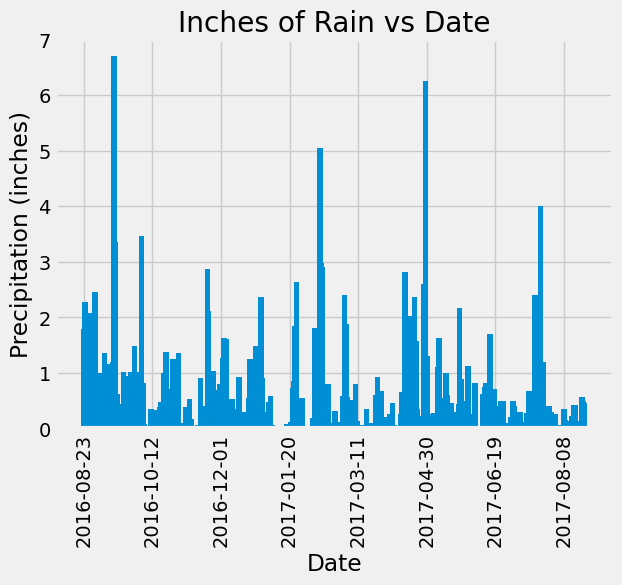

In [197]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
y = int(starting_point[:4])
m = int(starting_point[6:7])
d = int(starting_point[-2:])
starting_point = dt.date(y,m,d)

# Calculate the date one year from the last date in data set.
ending_point = starting_point - dt.timedelta(days=365)
ending_point

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date,measurement.prcp).filter(measurement.date >= ending_point).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.read_sql(f"SELECT date, prcp FROM measurement WHERE date >= '{ending_point}'",con=conn)

# Sort the dataframe by date
df = df.sort_values(by="date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(df["date"],df["prcp"],width=4)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.ylim(0,7)
plt.title("Inches of Rain vs Date")
plt.xticks(ticks=[0,50,100,150,200,250,300,350],rotation=90)


In [199]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [222]:
# Design a query to calculate the total number of stations in the dataset
session.query(measurement.station).distinct().count()

9

In [223]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_activity

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 4.183333333333314, 'Temperature')

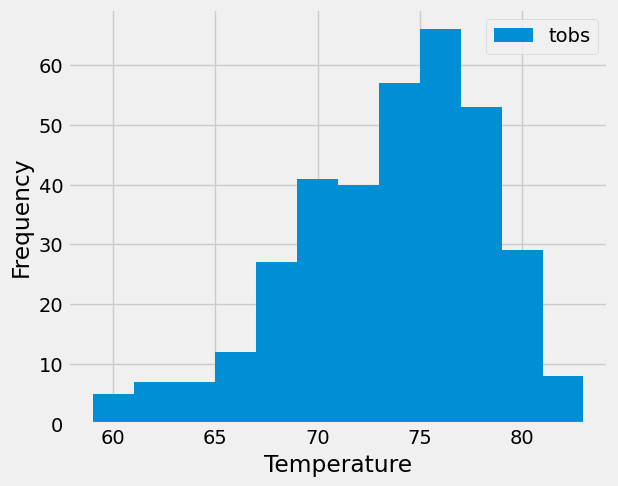

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()